# Fully local webscraper for manufacturing

## Imports

In [97]:
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Langchain setup
from langchain_core.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_ollama import OllamaLLM
import json, re

#DDG
from duckduckgo_search import DDGS

# Fetching HTML
from langchain_community.document_loaders import AsyncHtmlLoader
from langchain_community.document_transformers import Html2TextTransformer

# Web scraping
import asyncio

# Database
from bs4 import BeautifulSoup
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.vectorstores import Chroma
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA

import os, glob
from langchain.document_loaders import PyPDFLoader
from langchain.schema import Document
from langchain.vectorstores import Chroma, FAISS
import shutil
from chromadb.config import Settings


## Setup BLIP-2

Using BLIP-2 as captioning model

In [69]:
from huggingface_hub import snapshot_download
# this will cache everything under ~/.cache/huggingface/hub or in `cache_dir`
local_dir = snapshot_download(
  repo_id="Salesforce/blip2-opt-2.7b",
  repo_type="model",
  local_dir="./models/blip2-opt-2.7b",
  local_dir_use_symlinks=False
)
print("Saved to", local_dir)

/home/apoorv/miniconda3/envs/ragenv/lib/python3.10/site-packages/huggingface_hub/file_download.py:933: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(
Fetching 18 files: 100%|██████████| 18/18 [00:00<00:00, 4271.43it/s]

Saved to /home/apoorv/local-deep-research/models/blip2-opt-2.7b


`processor` is a convenience object, that handles all pre and post processing steps. Internally it:
1. Converts your raw image into the pixel tensor format the model expects.
2. Tokenizes your text prompt into input IDs and attention masks.
3. After generation, decodes the model’s token IDs back into readable text.
`model` is the actual BLIP-2 vision-language model. It takes the preprocessed image+text tensors from `processor`, runs the multi-modal encoder/decoder and generates new token IDs as its answer. These IDs are sent back through the `processor` for decoding.

In [70]:
# Hugging Face Image Captioning Model Setup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained model and feature extractor
# BLIP2 Image Captioning
repo_dir = "./models/blip2-opt-2.7b"   # wherever you snapshot_downloaded it

processor = Blip2Processor.from_pretrained(repo_dir, local_files_only=True)
model     = Blip2ForConditionalGeneration.from_pretrained(
               repo_dir,
               local_files_only=True,
               torch_dtype=torch.float16
            )

# Print device information
print(f"Using device: {device}")

Loading checkpoint shards: 100%|██████████| 2/2 [00:09<00:00,  4.92s/it]


Using device: cuda


### Using BLIP-2 to generate captions

The flow here is: write the initial `prompt` for the image, send the image and `prompt` to the `processor` to produce model `inputs`, pass those `inputs` into the `model` to get `generated_ids`, decode `generated_ids` via the `processor` to text, append the new question onto that decoded text to form a new `prompt`, send the image and new `prompt` back to the `processor` to get `inputs` again, feed those `inputs` into the `model` to get a second set of `generated_ids`, and finally decode those `generated_ids` via the `processor` to obtain the final `generated_text`.

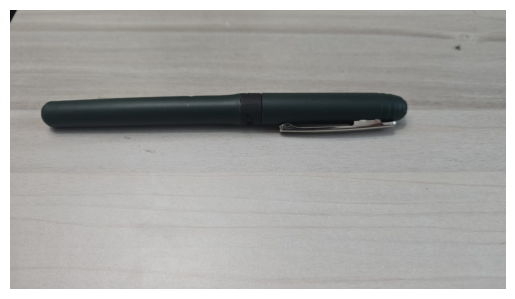

Question: What is the object in the image? Answer: a fountain pen. Question: What is the material of the pen? Answer: a plastic pen.


In [71]:
obj_img_path = 'obj.jpeg'

# Load the image with PIL
image = Image.open(obj_img_path)

# Display the image with matplotlib
plt.imshow(image)
plt.axis('off')  # Hide axes for better visualization
plt.show()

# Prepare the initial prompt asking the model to identify the object in the image
prompt = "Question: What is the object in the image? Answer:"

# Tokenize the image and prompt, convert to PyTorch tensors
inputs = processor(image, text=prompt, return_tensors="pt").to("cpu", torch.float16)
# Generate up to 10 tokens as the model's answer
generated_ids = model.generate(**inputs, max_new_tokens=10)
# Decode the generated tokens back to text, strip special tokens and whitespace,
# then append a new question about the pen's material
prompt = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip() \
         + ". Question: What is the material of the pen? Answer:"

# Tokenize the updated prompt and image again for the follow-up question
inputs = processor(image, text=prompt, return_tensors="pt").to("cpu", torch.float16)
# Generate up to 10 tokens for the follow-up answer
generated_ids = model.generate(**inputs, max_new_tokens=10)
# Decode the final generated tokens to obtain the answer text
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

# Print the final answer about the pen's material
print(generated_text)


## Generate queries

The LLM Model: Ollama gemma3:4b model will be used for query generation as well as final manufacturing document generation

In [72]:
# Initialize your LLM
llm = OllamaLLM(model="gemma3:4b", temperature=0.3)

# Prompt template for queries
query_prompt = PromptTemplate.from_template("""
You are a manufacturing research assistant.
Given the object description below, generate {k} diverse DuckDuckGo
search queries that will retrieve:
  • step-by-step manufacturing guides  
  • sustainable material options  
  • cost analyses  

Return only a JSON array of query strings.

Description:
"{caption}"
""")

def generate_queries(caption: str, k: int = 6) -> list[str]:
    chain = LLMChain(llm=llm, prompt=query_prompt.partial(k=k))
    out_dict = chain.invoke({"caption": caption})
    raw      = out_dict["text"].strip()      # ← extract the string
    match    = re.search(r"\[.*\]", raw, re.DOTALL)
    if not match:
        raise ValueError(f"Could not parse JSON from model:\n{raw}")
    return [q.strip() for q in json.loads(match.group(0))]


In [73]:
queries = generate_queries(generated_text)
print("Generated queries:")
for q in queries:
    print(f"  • {q}")

Generated queries:
  • DIY fountain pen manufacturing guide
  • sustainable pen materials cost analysis
  • eco-friendly fountain pen production steps
  • plastic pen manufacturing cost breakdown
  • sustainable writing instrument material sourcing
  • low-cost fountain pen design and fabrication


## Dynamic DB

### Duck-Duck-Go scraping for top N URLs

In [74]:
def ddg_search(query: str, max_results: int = 5) -> list[str]:
    """
    Returns the top‑N DuckDuckGo result URLs for a query.
    """
    with DDGS() as ddgs:
        return [hit["href"] for hit in ddgs.text(query, max_results=max_results)]

# Example usage:
# urls = [u for q in queries for u in ddg_search(q, max_results=5)]
# urls = list(dict.fromkeys(urls))  # dedupe while preserving order

In [75]:
async def fetch_documents(urls: list[str]):
    """
    Asynchronously downloads each page and converts HTML→plain text.
    Returns a list of LangChain Document objects.
    """
    loader    = AsyncHtmlLoader(urls)
    html_docs = await loader.load()                       # list[Document] with HTML in .page_content
    transformer = Html2TextTransformer()                  # strips tags, yields markdown‑style text :contentReference[oaicite:0]{index=0}
    text_docs = transformer.transform_documents(html_docs)
    return text_docs


In [76]:
all_urls = []
for q in queries:
    urls = ddg_search(q, max_results=5)
    print(f"\nQuery: {q}\n  URLs:")
    for u in urls:
        print("    •", u)
    all_urls.extend(urls)

unique_urls = list(dict.fromkeys(all_urls))
print(f"\nTotal unique URLs: {len(unique_urls)}")



Query: DIY fountain pen manufacturing guide
  URLs:
    • https://fountainpenguide.com/how-to-make-a-fountain-pen/
    • https://hogonext.com/how-to-make-a-pen/
    • https://woodfountainpens.com/blogs/the-fountain-pen-journal/creating-your-dream-custom-fountain-pen-a-step-by-step-guide
    • https://www.wikihow.com/Make-a-Pen
    • https://www.timberbits.com/blog/how-i-make-pens-step-by-step-instructions/

Query: sustainable pen materials cost analysis
  URLs:
    • https://jestec.taylors.edu.my/Special+Issue+ISCoE+2024_1/ISCoE2024_1_18.pdf
    • https://www.theenvironmentalblog.org/2025/03/bamboo-to-recycled-plastic-materials-green-pens/
    • https://www.theinsightpartners.com/reports/pens-market
    • https://left-handesign.com/blogs/news/plastic-vs-sustainable-stationery
    • https://zerowastememoirs.com/zero-waste-pens/

Query: eco-friendly fountain pen production steps
  URLs:
    • https://www.theenvironmentalblog.org/2025/03/bamboo-to-recycled-plastic-materials-green-pens/
 

### Fetch HTML Docs as plain text

In [77]:
N = 25
print(f"\nFetching and parsing first {N} available pages:")

html_docs = []
success_count = 0
failure_count = 0

for idx, url in enumerate(unique_urls[:N], start=1):
    single_loader = AsyncHtmlLoader([url])
    try:
        docs_for_url = await asyncio.wait_for(
            asyncio.to_thread(single_loader.load),
            timeout=10
        )
        html_docs.extend(docs_for_url)
        print(f"[{idx}/{N}] ✓ Fetched {url}")
        success_count += 1

    except asyncio.TimeoutError:
        failure_count += 1
        print(f"[{idx}/{N}] ✗ Timeout {url}")
    except Exception as e:
        failure_count += 1
        print(f"[{idx}/{N}] ✗ Error {url}: {e}")

print(f"\nCompleted: {success_count} succeeded, {failure_count} failed out of {N} URLs.\n")

# Transform and inspect as before
transformer = Html2TextTransformer()
docs = transformer.transform_documents(html_docs)

# Iterate through the documents and print excerpts
for i, doc in enumerate(docs, 1):
    src     = doc.metadata.get("source", "unknown")
    excerpt = doc.page_content.replace("\n", " ")[:10000]
    print(f"\nDocument {i} — source: {src}")
    print("Excerpt:", excerpt, "…")
    print("-" * 80)



Fetching and parsing first 25 available pages:


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  7.50it/s]

[1/25] ✓ Fetched https://fountainpenguide.com/how-to-make-a-fountain-pen/



Fetching pages: 100%|##########| 1/1 [00:02<00:00,  2.39s/it]


[2/25] ✓ Fetched https://hogonext.com/how-to-make-a-pen/


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  5.22it/s]


[3/25] ✓ Fetched https://woodfountainpens.com/blogs/the-fountain-pen-journal/creating-your-dream-custom-fountain-pen-a-step-by-step-guide


Fetching pages: 100%|##########| 1/1 [00:00<00:00, 14.69it/s]


[4/25] ✓ Fetched https://www.wikihow.com/Make-a-Pen


Fetching pages: 100%|##########| 1/1 [00:01<00:00,  1.82s/it]


[5/25] ✓ Fetched https://www.timberbits.com/blog/how-i-make-pens-step-by-step-instructions/


Fetching pages: 100%|##########| 1/1 [00:02<00:00,  2.08s/it]


[6/25] ✓ Fetched https://jestec.taylors.edu.my/Special+Issue+ISCoE+2024_1/ISCoE2024_1_18.pdf


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  3.53it/s]


[7/25] ✓ Fetched https://www.theenvironmentalblog.org/2025/03/bamboo-to-recycled-plastic-materials-green-pens/


Fetching pages: 100%|##########| 1/1 [00:00<00:00, 17.35it/s]


[8/25] ✓ Fetched https://www.theinsightpartners.com/reports/pens-market


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  1.89it/s]


[9/25] ✓ Fetched https://left-handesign.com/blogs/news/plastic-vs-sustainable-stationery


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  2.82it/s]


[10/25] ✓ Fetched https://zerowastememoirs.com/zero-waste-pens/


Fetching pages:   0%|          | 0/1 [00:00<?, ?it/s]

[11/25] ✗ Timeout https://ecofriendlyguides.com/make-an-ecofriendly-pen/


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  1.96it/s]


[12/25] ✓ Fetched https://medium.com/@ecopromotionsseo/how-recycled-pens-are-made-from-waste-to-writing-tools-612c8bf38cb5


Fetching pages: 100%|##########| 1/1 [00:01<00:00,  1.07s/it]


[13/25] ✓ Fetched https://www.deliworld.com/from-waste-to-writing-how-recycled-ocean-plastics-become-pens.html


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  8.06it/s]


[14/25] ✓ Fetched https://woodfountainpens.com/blogs/the-fountain-pen-journal/the-sustainable-choice-eco-friendly-benefits-of-fountain-pens-1


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  3.26it/s]


[15/25] ✓ Fetched https://www.ttxpens.com/pen-manufacturing-cost/


Fetching pages: 100%|##########| 1/1 [00:00<00:00, 11.61it/s]


[16/25] ✓ Fetched https://mixedkreations.com/how-much-does-it-cost-to-make-a-pen/


Fetching pages: 100%|##########| 1/1 [00:01<00:00,  1.23s/it]


[17/25] ✓ Fetched https://www.allaboutlean.com/how-cheap-can-you-make-it/


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  1.72it/s]


[18/25] ✓ Fetched https://www.imarcgroup.com/disposable-ball-pen-manufacturing-plant-project-report


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  4.55it/s]


[19/25] ✓ Fetched https://jiantai.io/how-to-calculate-your-plastic-product-manufacturing-costs/


Fetching pages: 100%|##########| 1/1 [00:00<00:00, 13.03it/s]


[20/25] ✓ Fetched https://www.consumerenergycenter.org/eco-friendly-pens/


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  6.55it/s]


[21/25] ✓ Fetched https://www.ethicallyengineered.com/eco-friendly-pens/


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  1.55it/s]


[22/25] ✓ Fetched https://ethical.net/sustainability/sustainable-writing-utensils/


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  2.93it/s]


[23/25] ✓ Fetched https://thefountainpenismightier.com/how-much-does-it-cost-to-make-a-fountain-pen/


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  2.64it/s]


[24/25] ✓ Fetched https://www.galenleather.com/blogs/news/custom-pen-makers


Fetching pages: 100%|##########| 1/1 [00:00<00:00, 19.30it/s]


[25/25] ✓ Fetched https://fountainpendesign.wordpress.com/

Completed: 24 succeeded, 1 failed out of 25 URLs.


Document 1 — source: https://fountainpenguide.com/how-to-make-a-fountain-pen/
Excerpt: Skip to content    * Fountain Pens   * Ink   * Guides   * Office   * About Us  ____ Menu    * Fountain Pens   * Ink   * Guides   * Office   * About Us  __ Search  How to Make a Fountain Pen: A Step-by-Step Guide  Do you love the feel and look of a fountain pen? Have you ever wanted to make your own? This step-by-step guide will show you how to make a fountain pen from scratch!  Fountain pens are a great way to show your personality, style, and make your writing more enjoyable.  ## What Is a Fountain Pen?  A fountain pen is a type of pen that uses liquid ink instead of oil-based ink, which is often used in ballpoint pens.  The ink is stored in a reservoir inside the pen, and a feed system allows the ink to flow to the nib.  Fountain pens can be found in various styles and have price points, 

Error fetching https://ecofriendlyguides.com/make-an-ecofriendly-pen/ with attempt 1/3: Connection timeout to host https://ecofriendlyguides.com/make-an-ecofriendly-pen/. Retrying...
Error fetching https://ecofriendlyguides.com/make-an-ecofriendly-pen/ with attempt 2/3: Connection timeout to host https://ecofriendlyguides.com/make-an-ecofriendly-pen/. Retrying...
Fetching pages:   0%|          | 0/1 [01:37<?, ?it/s]


### Convert fetched HTML into LangChain Documents

In [78]:
# Dynamic Database: ddb
ddb = []

for html_doc in html_docs: 
    # Get the url
    url = html_doc.metadata.get("source", "unknown")
    # Parse the HTML content
    soup = BeautifulSoup(html_doc.page_content, "html.parser") 
    # Extract text from <p> tags
    text = "\n\n".join(p.get_text() for p in soup.find_all("p")) 
    # Add to ddb
    ddb.append(Document(page_content=text, metadata={"source": url})) 

# ddb

In [79]:
# Split each Document into overlapping chunks for retrieval
splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,
    chunk_overlap=200,
    length_function=len
)
ddb = splitter.split_documents(ddb)

embedder = SentenceTransformerEmbeddings(
    model_name="all-MiniLM-L6-v2",
    model_kwargs={"device": "cpu"}
)

vectordb_dynamic = FAISS.from_documents(
    documents=ddb,    # your list of Document chunks
    embedding=embedder
)

## Static DB

In [96]:
static_dir = "db/sdb"

# Check if the static directory exists and is not empty
if os.path.exists(static_dir) and os.listdir(static_dir):
    # Load existing Chroma vector store
    print(f"Loading existing vector store from {static_dir}")
    vectordb_static = Chroma(
        persist_directory=static_dir,
        embedding_function=embedder
    )

# Check if the vector store is empty
else:
    print(f"Building new vector store in {static_dir}")

    # 1) Remove any stale files so we start clean
    if os.path.exists(static_dir):
        shutil.rmtree(static_dir)
    os.makedirs(static_dir, exist_ok=True)

    # 2) Load and split your PDFs
    pdf_docs = []
    for path in glob.glob("data/*.pdf"):
        loader = PyPDFLoader(path)
        pdf_docs.extend(loader.load())

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=1500,
        chunk_overlap=200,
        length_function=len
    )
    static_chunks = splitter.split_documents(pdf_docs)

    # 3) Configure Chroma to use DuckDB+Parquet instead of SQLite
    client_settings = Settings(
        chroma_db_impl="duckdb+parquet",
        persist_directory=static_dir
    )

    # 4) Build (and persist) the new vector store
    vectordb_static = Chroma.from_documents(
        documents=static_chunks,
        embedding=embedder,
        client_settings=client_settings
    )
    vectordb_static.persist()

Building new vector store in db/sdb


ValueError: [91mYou are using a deprecated configuration of Chroma.

[94mIf you do not have data you wish to migrate, you only need to change how you construct
your Chroma client. Please see the "New Clients" section of https://docs.trychroma.com/deployment/migration.
________________________________________________________________________________________________

If you do have data you wish to migrate, we have a migration tool you can use in order to
migrate your data to the new Chroma architecture.
Please `pip install chroma-migrate` and run `chroma-migrate` to migrate your data and then
change how you construct your Chroma client.

See https://docs.trychroma.com/deployment/migration for more information or join our discord at https://discord.gg/MMeYNTmh3x for help![0m

## Create Retrievers

In [ ]:
# Define a simple wrapper that queries both static & dynamic stores
class CombinedRetriever:
    def __init__(self, retrievers, k=5):
        self.retrievers = retrievers
        self.k = k
    def get_relevant_documents(self, query):
        docs = []
        for r in self.retrievers:
            docs.extend(r.get_relevant_documents(query))
        # Return top k combined
        return docs[: self.k]

retriever = CombinedRetriever([
    vectordb_static.as_retriever(search_kwargs={"k": 3}),
    vectordb_dynamic.as_retriever(search_kwargs={"k": 3}),
], k=5)

In [64]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True
)

## Ask the LLM

Finally, prompt the LLM with the final query

In [ ]:
# 1. Get your BLIP2 object description
object_desc = generated_text

# 2. Formulate a concrete manufacturing question
query = (
    f"The object in the image is: {object_desc}.  "
    "Please provide a detailed, step‑by‑step manufacturing guide for this object in 1000 words."
)

# 3. Run your RetrievalQA chain
result = qa_chain({"query": query})
guide   = result["result"]
sources = result["source_documents"]

# 4. Display
print("\n Guide:\n", guide)
print("\n Sources:")
for d in sources:
    print(" -", d.metadata["source"])


 Guide:
 Okay, based on the provided text, here’s a detailed, step-by-step manufacturing guide for a fountain pen, incorporating the information about both mass-produced and artisanal methods:

**Manufacturing Guide: Fountain Pen**

**I. Material Preparation & Component Creation:**

1.  **Plastic Component Production (Mass-Produced):**
    *   **Injection Molding:** Molten plastic is injected into a mold to create the pen body, ink reservoir, and other plastic parts.
    *   **Extrusion Molding:** Heated plastic is forced through a die to form the pen body and ink reservoir.

2.  **Nib Creation:**
    *   **Metal Cutting/Stamping/Machining:** Metal (gold, stainless steel, or titanium) is cut, stamped, or machined into the basic nib shape. CNC machines are used for intricate designs.
    *   **Tipping Material Attachment:** The tipping material (metal) is attached to the nib end using welding or adhesive bonding.

3.  **Artisanal Production (Handcrafted):**
    *   **Lathe Turning:** R